<a href="https://colab.research.google.com/github/hucarlos08/Nerf-Geo/blob/main/Rendering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Generating Images: Rendering: From 3D Data to 2D Pixels

We have our 3D representations and a model for how cameras capture light. Now, let's dive into the process of rendering, which is the art and science of creating 2D images from 3D scenes. Rendering algorithms simulate how light interacts with objects in the scene and determine the final color of each pixel in the image.

**The Rendering Equation**

The rendering equation is the fundamental mathematical equation that governs how light behaves in a scene:

$$
L_o(x, \omega_o) = L_e(x, \omega_o) + \int_{\Omega} f_r(x, \omega_i, \omega_o) L_i(x, \omega_i) cos(\theta_i) d\omega_i
$$

Let's break it down:

* $L_o(x, \omega_o)$: Outgoing radiance (light) from point $x$ in direction $ω_o$. This is what we want to compute – the color of a pixel.
* $L_e(x, \omega_o)$: Emitted radiance from point $x$ in direction $ω_o$. This is the light emitted by the object itself.
* Integral: The integral sums up the light coming from all directions $\omega_i$.
* $f_r(x, \omega_i, \omega_o)$: Bidirectional Reflectance Distribution Function (BRDF). This describes how the surface at point $x$ reflects light from direction $\omega_i$ to direction $\omega_o$.
* $L_i(x, \omega_i)$: Incoming radiance from direction $\omega_i$. This is the light hitting the surface.
* $cos(\theta_i)$: The cosine of the angle between the incoming light direction and the surface normal. This accounts for the foreshortening effect.



## Rendering Algorithms

There are two main approaches to solving the rendering equation:

### Ray Tracing: Following the Light

| ![2d-train](https://imgur.com/ElFbsHl.png) |
| :---: |
| **Figure 1**: Ray traicing. |

* **The Concept:** Imagine shooting rays of light from the camera through each pixel in the image.  Trace each ray as it bounces around the scene, interacting with objects, until it either hits a light source or goes off into infinity.  The final color of the pixel is determined by the light that the ray accumulates along its path.
* **Advantages:**  Ray tracing can produce highly realistic images with accurate lighting and reflections.
* **Disadvantages:**  Ray tracing can be computationally expensive, especially for complex scenes.


### Introduction to Ray Tracing

Ray tracing is a rendering technique for generating an image by tracing the path of light as pixels in an image plane and simulating the effects of its encounters with virtual objects. It can produce highly realistic images by accurately simulating various optical effects such as reflection, refraction, and shadows.

#### Basic Concepts and Equations

1. **Ray Representation:**
   A ray is represented by an origin $\mathbf{O}$ and a direction $\mathbf{D}$:
   $
   \mathbf{R}(t) = \mathbf{O} + t\mathbf{D}
   $
   where $t$ is a parameter.

2. **Sphere Intersection:**
   To determine if a ray intersects a sphere, we solve the quadratic equation:
   $
   \mathbf{R}(t) = \mathbf{O} + t\mathbf{D}
   $
   Substituting this into the equation of a sphere $(\mathbf{P} - \mathbf{C}) \cdot (\mathbf{P} - \mathbf{C}) = R^2$, where $\mathbf{C}$ is the center and $R$ is the radius, we get:
   $
   (\mathbf{O} + t\mathbf{D} - \mathbf{C}) \cdot (\mathbf{O} + t\mathbf{D} - \mathbf{C}) = R^2
   $
   This simplifies to:
   $
   t^2(\mathbf{D} \cdot \mathbf{D}) + 2t(\mathbf{D} \cdot (\mathbf{O} - \mathbf{C})) + (\mathbf{O} - \mathbf{C}) \cdot (\mathbf{O} - \mathbf{C}) - R^2 = 0
   $
   Solving this quadratic equation for $t$ gives us the points of intersection.

3. **Reflection:**
   The reflection of a ray direction $\mathbf{D}$ off a surface with normal $\mathbf{N}$ is given by:
   $
   \mathbf{R} = \mathbf{D} - 2(\mathbf{D} \cdot \mathbf{N})\mathbf{N}
   $

4. **Illumination Model:**
   The color at each point is computed using a simplified Phong reflection model, which includes ambient, diffuse, and specular components:
   $
   \mathbf{I} = \mathbf{I}_{ambient} + \mathbf{I}_{diffuse} + \mathbf{I}_{specular}
   $
   where:
   - $\mathbf{I}_{ambient} = k_a \mathbf{L}_{ambient}$
   - $\mathbf{I}_{diffuse} = k_d (\mathbf{L}_{diffuse} \cdot \mathbf{N})$
   - $\mathbf{I}_{specular} = k_s (\mathbf{R} \cdot \mathbf{V})^n \mathbf{L}_{specular}$

   Here, $\mathbf{L}$ is the light vector, $\mathbf{N}$ is the normal at the surface, $\mathbf{V}$ is the view vector, $k_a$, $k_d$, and $k_s$ are material properties, and $n$ is the shininess exponent.



### Rasterization: Projecting and Coloring

| ![2d-train](https://imgur.com/5zjuSv1.png) |
| :---: |
| **Figure 1**: Rasterization. |

* **The Concept:** Break down 3D objects into triangles (if they are meshes) and project them onto the image plane. Determine which pixels are covered by each triangle, and then color those pixels based on the triangle's material properties and lighting conditions.
* **Advantages:**  Rasterization is much faster than ray tracing, making it suitable for real-time applications like video games.
* **Disadvantages:** Rasterization often produces less realistic images than ray tracing, with simplified lighting and reflections.

### Differentiable Rendering: Optimization Powerhouse

* **The Concept:**  While not a rendering algorithm itself, differentiable rendering is a crucial technique in NeRF. It allows us to calculate the gradient of the image with respect to the scene parameters. This enables us to optimize the scene representation (in the case of NeRF, the neural network parameters) to match observed images.

**Relevance to NeRF: NeRF uses differentiable rendering to train its neural network to represent scenes accurately.**



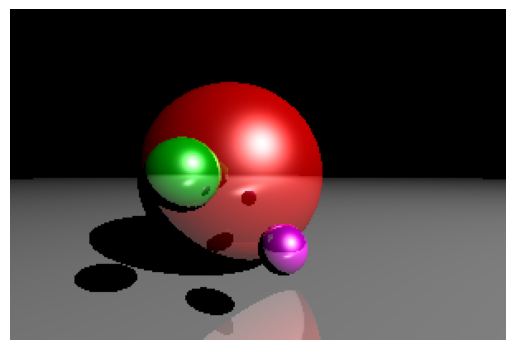

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(vector):
    """Normalize a vector."""
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    """Calculate the reflection of a vector from an axis."""
    return vector - 2 * np.dot(vector, axis) * axis

def sphere_intersect(center, radius, ray_origin, ray_direction):
    """
    Check if a ray intersects with a sphere.

    Parameters:
    - center: The center of the sphere.
    - radius: The radius of the sphere.
    - ray_origin: The origin of the ray.
    - ray_direction: The direction of the ray.

    Returns:
    - Distance to the intersection point or None if no intersection.
    """
    b = 2 * np.dot(ray_direction, ray_origin - center)
    c = np.linalg.norm(ray_origin - center) ** 2 - radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None

def nearest_intersected_object(objects, ray_origin, ray_direction):
    """
    Find the nearest object intersected by a ray.

    Parameters:
    - objects: A list of objects (spheres).
    - ray_origin: The origin of the ray.
    - ray_direction: The direction of the ray.

    Returns:
    - Nearest intersected object and the distance to the intersection.
    """
    distances = [sphere_intersect(obj['center'], obj['radius'], ray_origin, ray_direction) for obj in objects]
    nearest_object = None
    min_distance = np.inf
    for index, distance in enumerate(distances):
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]
    return nearest_object, min_distance

def render_scene(width, height, max_depth, camera, screen, light, objects):
    """
    Render the scene using ray tracing.

    Parameters:
    - width: Width of the output image.
    - height: Height of the output image.
    - max_depth: Maximum recursion depth for reflections.
    - camera: The camera position.
    - screen: The screen dimensions (left, top, right, bottom).
    - light: The light source parameters.
    - objects: A list of objects in the scene.

    Returns:
    - The rendered image.
    """
    image = np.zeros((height, width, 3))

    for i, y in enumerate(np.linspace(screen[1], screen[3], height)):
        for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
            pixel = np.array([x, y, 0])
            origin = camera
            direction = normalize(pixel - origin)

            color = np.zeros((3))
            reflection = 1.0

            for _ in range(max_depth):
                nearest_object, min_distance = nearest_intersected_object(objects, origin, direction)
                if nearest_object is None:
                    break

                intersection = origin + min_distance * direction
                normal_to_surface = normalize(intersection - nearest_object['center'])
                shifted_point = intersection + 1e-5 * normal_to_surface
                intersection_to_light = normalize(light['position'] - shifted_point)

                _, min_distance = nearest_intersected_object(objects, shifted_point, intersection_to_light)
                intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
                is_shadowed = min_distance < intersection_to_light_distance

                if is_shadowed:
                    break

                illumination = np.zeros((3))

                # Ambient
                illumination += nearest_object['ambient'] * light['ambient']

                # Diffuse
                illumination += nearest_object['diffuse'] * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

                # Specular
                intersection_to_camera = normalize(camera - intersection)
                H = normalize(intersection_to_light + intersection_to_camera)
                illumination += nearest_object['specular'] * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object['shininess'] / 4)

                # Reflection
                color += reflection * illumination
                reflection *= nearest_object['reflection']

                origin = shifted_point
                direction = reflected(direction, normal_to_surface)

            image[i, j] = np.clip(color, 0, 1)

    return image

# Scene parameters
width = 300
height = 200
max_depth = 3
camera = np.array([0, 0, 1])
ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio)  # left, top, right, bottom
light = {
    'position': np.array([5, 5, 5]),
    'ambient': np.array([1, 1, 1]),
    'diffuse': np.array([1, 1, 1]),
    'specular': np.array([1, 1, 1])
}
objects = [
    {'center': np.array([-0.2, 0, -1]), 'radius': 0.7, 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5},
    {'center': np.array([0.1, -0.3, 0]), 'radius': 0.1, 'ambient': np.array([0.1, 0, 0.1]), 'diffuse': np.array([0.7, 0, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5},
    {'center': np.array([-0.3, 0, 0]), 'radius': 0.15, 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5},
    {'center': np.array([0, -9000, 0]), 'radius': 9000 - 0.7, 'ambient': np.array([0.1, 0.1, 0.1]), 'diffuse': np.array([0.6, 0.6, 0.6]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5}
]

# Render the scene
image = render_scene(width, height, max_depth, camera, screen, light, objects)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()
